# Complex Sentiment Analysis
This notebook gives you the frequency of positive and negaitive words from a Sentiment Lexicon appearing in a dataset. This allows you to see what positive and negative terms are most likely to influence your sentiment results and to make any adjustments that might be needed to your dataset.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/drafts/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.  

#### Opening data files

The needed positive and negative word lists are .csv files found in the [data > twitter > dict](https://github.com/cyberdh/Text-Analysis/tree/master/data/twitter/dict) folder.



### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different packages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by simply typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **re:** Provides regular expression matching operations similar to those found in Perl.
- **json:** Used to parse and manipulate data in JSON format.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.
- **nltk:** Platform for building Python programs to work with human language data. Here we bring in the VADER sentiment analysis tool which is now a part of the nltk package.
- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
- **numpy:** The fundamental package for scientific computing with Python.
- **collections:** Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers, dict, list, set, and tuple.
- **zipfile:** Allows for handling of zipfiles.

In [2]:
import pandas as pd
import re
import json
import glob
import nltk
import matplotlib.pyplot as plt
#import numpy as np
from collections import Counter
import zipfile

### Variables
Here we create some variables for use later in our code. We do this to minimize the number and complexity of the changes you will need to make later.

First we need to decide if we want to read in one file or a whole directory of files. If you want to read in a whole directory then set `source` equal to `"*"` as this is what is called a regular expression that means 'all'. So we are reading in 'all' the files in a directory. If you wish to read in a single file then set `source` equal to the name of the desired file in quotes, but leaving the '.json' or '.csv' off at the end. So a single file should look like this: `source = "myFileName"`.

Next we assign the file type our data comes in to a variable. At the moment the only options are '.csv' or '.json' as these are the most popular forms that twitter data comes in. We assign the file type to the `fileType` variable. It should look like this: `fileType = ".json"`.

The next three variables we assign column header names to. The `negColHead` variable is the column header for our list of negative words in our '.csv' file. The `posColHead` variable is the column header for our list of positive words in the positive words '.csv' file. Finally, the `tweetColHead` variable is the column header for the resulting dataframe our tweets are stored in further down in the code. If your tweets or positive and negative lexicons have different column headers, then make these adjustments here.

The variable `encoding` is where you determine what type of encoding to use (ascii, ISO-8850-1, utf-8, etc...). We have it set to utf-8 at the moment as we have found it is less likely to have any problems.

The next four variables are lists where you will add terms that may need to be added or removed from your positive and negative word list. This is because sentiment is often dependent on the topic. When discussing racial relations the word 'supremacy' is generally not a positive term, while a collection of recipes the word is fine. The `remNegWords` variable is where you will add words to remove from the negative list and `negAdds` is where you put words you want to add to the negative list. Always make sure your words are in quotes and separated by a comma. Thus, the `remPosWords` and `posAdds` do the same thing, but for the positive word list. 

In [3]:
source = "iranTweets"
fileType = ".json"
negColHead = 'Neg'
posColHead = 'Pos'
tweetColHead = 'text'
encoding = "utf-8"
remNegWords = []
negAdds = []
remPosWords = ['3']
posAdds = []

### File paths
Here we assign file paths we will need throughout this notebook to variables. This way we only need to make changes here and they will be implemeneted throughout the code. The `homePath` variable uses the `environ` function from the `os` package. This function points to your home directory no matter your operating system (Linux, osX, Windows).

Then we join the `homePath` variable to folders that point to where our data is stored and we assign this file path to the variable `dataHome`. The folder names are in quotes and separated by a comma. 

Next, we again use the `homePath` variable and join it with a file path that points to a folder where we can save any output. We assign this file path to a variable called `dataResults`.

Finally, we assign paths that point to a negative word list and a positive word list from the VADER lexicon to two separate variables. The `negFile` variable is for the negative list and `posFile` is for the positive list. 

You can change any of these to better match your data and your research needs. Just remember to put all folders or file names in quotes and separate them with a comma.

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, 'Text-Analysis-master','data','twitter')
dataResults = os.path.join(homePath, 'Text-Analysis-master', 'Output')
negFile = glob.glob(os.path.join(dataHome, "dict", "negativeVADER.csv"))
posFile = glob.glob(os.path.join(dataHome, "dict", "positiveVADER.csv"))

##### Load the negative words

Here we read in our negative words. First we read in the '.csv' file containing our negative words from the VADER lexicon. Then we turn it into a dataframe and assign the dataframe to the variable `negDf`. Next we change the dataframe to a list and assign the list to the variable `negTokens`. Then we add words to the list that we added to the `negAdds` variable from above, followed by removing any words that we added to the `remNegWords` variable. Lastly, we set the list, which uses a hash table to make looking up an item in the list more efficient. There should be no need to make changes to this code.

In [5]:
for f in negFile:
    negText = pd.read_csv(f, index_col = False)

negDf = pd.DataFrame(negText)
negTokens = negDf[negColHead].tolist()
 
negTokens.extend(negAdds)
for word in list(negTokens):
    if word in remNegWords: 
        negTokens.remove(word)
print(negTokens[-10:])

# list to set for efficient lookup
negTokens = set(negTokens)

['trembles', 'trivial', 'unbiased', 'warsaw', 'wellhole', 'winnower', 'winnowing', 'wiseacres', 'wisecrack', 'wisecracker']


##### Load the positive words

Here we read in our positive words. First we read in the '.csv' file containing our positive words from the VADER lexicon. Then we turn it into a dataframe and assign the dataframe to the variable `posDf`. Next we change the dataframe to a list and assign the list to the variable `posTokens`. Then we add words to the list that we added to the `posAdds` variable from above, followed by removing any words that we added to the `remPosWords` variable. Lastly, we set the list, which uses a hash table to make looking up an item in the list more efficient. There should be no need to make changes to this code.

In [6]:
for f in posFile:
    posText = pd.read_csv(f, index_col = False)

posDf = pd.DataFrame(posText)
posTokens = posDf[posColHead].tolist()
posTokens.extend(posAdds)
for word in list(posTokens):
    if word in remPosWords: 
        posTokens.remove(word)
#if 'right' in posTokens: posTokens.remove('right')
print(posTokens[-10:])

# list to set for efficient lookup
posTokens = set(posTokens)

['paradise', 'perfectly', 'lya', 'ecstacy', 'euphoria', 'sweetheart', 'aml', 'ilu', 'ily', 'magnificently']


### Unzip files

Here we are unzipping files. Since twitter data can be rather large it is often necessary to compress it into a '.zip' file in order to upload it to places such as GitHub. For this reason, we have setup some code to go in and automatically extract all the items in a compressed '.zip' file so you do't have to and so you don't get errors later. If the data is not in a '.zip' file there is no need to worry, it will not give an error if there are no files ending in '.zip' in your directory.

The only changes you may wish to make are in the first two lines after `if fileType == ".csv":` (if you set `fileType` equal to `".csv"` above) or the first two lines after `else:` (if you set `fileType` equal to `".json"` up above. These are the lines that point to the file paths where your '.zip' files are stored. If you have '.zip' files stored in another folder you will want to change the path. Note that the first line points to the directory and the second line points to the files.  

In [7]:
if fileType == ".csv":
    direct = os.path.join(dataHome, "CSV", "Iran")
    allZipFiles = glob.glob(os.path.join(dataHome, "CSV", "Iran","*.zip"))
    for item in allZipFiles:
            fileName = os.path.splitext(direct)[0]
            zipRef = zipfile.ZipFile(item, "r")
            zipRef.extractall(fileName)
            zipRef.close()
            os.remove(item)
else:
    direct = os.path.join(dataHome, "JSON")
    allZipFiles = glob.glob(os.path.join(dataHome, "JSON","*.zip"))
    for item in allZipFiles:
            fileName = os.path.splitext(direct)[0]
            zipRef = zipfile.ZipFile(item, "r")
            zipRef.extractall(fileName)
            zipRef.close()
            os.remove(item)

### Reading in .csv and .json files

If you chose `".csv"` as your `fileType` up above, then the first `if` statement in the code below reads in ".csv" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".csv" file depending on what you chose for `source` above. 

Once we have read in the ".csv" file using the Pandas `read_csv` function, we need to concatenate the ".csv" files if there are multiple. Because of this it is important that your ".csv" files have an identical column count and each column has identical header names or you will get errors. If you have a single ".csv" file then you should be fine for this step. We assign this process to the variable `cdf` so we can use it later.

Now we convert our `cdf` to a pandas dataframe. This allows for easier manipulation of the data in the next line.

Finally, we pull in the column containing the data we are interested in which we assigned to the variable `tweetColHead` earlier and turn it into a list assigned to the variable `tweets`.

If you chose `".json"` for your fileType, then the second `if` statement will read in ".json" files and save the content to a dataframe using the Pandas package much like the ".csv" file process described above. The only difference is that we use the Pandas function `read_json` instead of `read_csv`. Everything else is exactly the same as what is described above in the ".csv" section. 

In [8]:
if fileType == ".csv":
    allFiles = glob.glob(os.path.join(dataHome, "CSV", "Iran", source + fileType))     
    df = (pd.read_csv(f, engine = "python") for f in allFiles)
    cdf = pd.concat(df, ignore_index=True)
    cdf = pd.DataFrame(cdf, dtype = 'str')
    tweetsTokens = cdf[tweetColHead].values.tolist()
if fileType == ".json":
    allFiles = glob.glob(os.path.join(dataHome, "JSON", source + fileType))     
    df = (pd.read_json(f, encoding = encoding) for f in allFiles)
    cdf = pd.concat(df, ignore_index=True)
    cdf = pd.DataFrame(cdf, dtype = 'str')
    tweetsTokens = cdf[tweetColHead].values.tolist()    
print(len(tweetsTokens)) 

21812


### Functions
We need to create a few functions in order to calculate and create a wordcloud. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Tokenizing the tweets

Now we will create two functions. The first for tokenizing a tweet, the second for calculating positive/negative words. Note that the `calulator` function uses the `tokenizer` function. Tokenizing means you break the text down into a token, generally a word, which is what the `tokenizer` function does. The `tokenizer` function also lower cases all the words in our tweets. Generally, this is an issue for VADER since capitalization can impact the score. However, since we are not actually using VADER, only the VADER lexicon, we need words in the lexicon to match the words in our tweets in order to be able to see which positive words and which negative words are most influential in the tweet scores. Then to calculate the positive and negative terms the function creates two empty lists, one for positive words (`posWordsList`) and one for negative words (`negWordsList`). We also have a counter for positive words (`numPosWords`) and for negative words (`numNegWords`). The function then uses the `tokenizer` function and breaks our tweets into individual words and lower cases the words. Then we take each word in our collection of tweets and check the positive word lexicon to see if it is listed. If it is, then we add a +1 to our `numPosWords` count and also add the word to our `posWordsList` list. Then we do the same thing for the negative word lexicon and add a +1 to `numNegWords` and add any words in our tweets that can be found in the negative word lexicon are also added to `negWordsList`.

Lastly we we get an overall score for each tweet by subtracting `numNegWords` from `numPosWords`. We assign this to the variable `score`. Then we return the `score` and the `posWordsList` and `negWordsList`.

In [9]:
def tokenizer(theText):
    theTokens = re.findall(r'\b\w[\w-]*\b', theText.lower())
    return theTokens

def calculator(theTweet, posTokenList, negTokenList):
    
    posWordsList = []
    negWordsList = []

    numPosWords = 0 
    numNegWords = 0
    
    theTweetTokens = tokenizer(theTweet)
    
    # Count positive and negative words
    for word in theTweetTokens:
        if word in posTokenList:
            numPosWords += 1
            posWordsList.append(word)
        
        if word in negTokenList:
            numNegWords += 1
            negWordsList.append(word)
        
        
    score = (numPosWords - numNegWords)
    return {'score': score, 'posWordsList' : posWordsList, 'negWordsList' : negWordsList}

## Analyzing tweets

Now we will use the calculator to calculate the scores of all the tweets. For each tweet in our `tweetsTokens` variable above we apply the `calculator` function and append the results to the variable `results` which is an empty list.

Then we pull the scores, positive words, and negative words out of the results list and assign them to variables `scores`, `posWordsList`, and `negWordsList` respectively.

In [10]:
# do all calculation once

results = []

for tweet in tweetsTokens:
    results.append(calculator(tweet, posTokens, negTokens))
    
scores = [x['score'] for x in results]

posWordsList = [x['posWordsList'] for x in results]
posWordsList = [item for sublist in posWordsList for item in sublist]

negWordsList = [x['negWordsList'] for x in results]
negWordsList = [item for sublist in negWordsList for item in sublist]

Here we look at the scores and sort them as either positive, negative, or neutral. To do this we have to prime some variables. We set `posi` and `nega` equal to 0. Then we assign the length of our `results` list to the variable `numTweets`. Next we set `numPosTweets`, `numNegTweets`, and `numNeutTweets` equal to 0.

Now, we iterate through our tweet scores. If the score in our `scores` variable is greater than `posi` then we increase `numPosTweets` by 1. If the score is less than `nega` than we increase `numNegTweets` by 1. If the score is not greater than `posi` or less than `nega` then `numNeutTweets` is increased by 1 as the only possible score is 0, which would be neutral. Then we print out the total number of tweets (`numTweets`) as well as the total number of positive tweets (`numPosTweets`), negative tweets (`numNegTweets`) and neutral tweets (`numNeutTweets`).

In [11]:
# Here we set up the thresholds
posi = 0 # This means there have to be at least 1 positive word
nega = 0 # This means there has to be at least 1 negative words

# Here we prime our variables
numTweets = len(results)
numPosTweets = 0
numNegTweets = 0
numNeutTweets = 0

# This loop goes through all the Tweets and calculates if sums the number of positive or negative ones.


for score in scores:
    if score > posi:
        numPosTweets += 1
       
    elif score < nega:
        numNegTweets += 1
        
    else:
        numNeutTweets += 1
        

# This prints out the results 
print("Total: " + str(numTweets) + "\n" + "Positive: " + str(numPosTweets) + "\n" + "Neutral: " + str(numNeutTweets) + "\n" + "Negative: " +str(numNegTweets))


Total: 21812
Positive: 5622
Neutral: 5772
Negative: 10418


#### Gathering positive tweets

This next cell will gather all examples of positive tweets. To do this we reset some of our variables from above. So `posi` now becomes 1. This means that the tweet will have to contain more than 1 positive word. The `numberWanted` variable is where you decide how many tweets you want to print out beneath this cell. Right now it is set to 4, but feel free to change it.

Next we reset `numTweets` and `numPosTweets` from above and we also assign an empty list to the variable `posiTweetList`.

Now that our variables are set we look through our `scores` and if any tweet has a score higher than `posi` then we append that tweet to the `posiTweetList` and increase `numPosTweets` by 1. Then, if `numPosTweets` is greater than or equal to `numberWanted` than we break, or stop. Lastly, we print out `posiTweetList`.

In [12]:
# Here we set up the threshold.
posi = 1 # This means there have to be more than 1 positive word
numberWanted = 4 # Here you decide how many tweets you want

# Here we prime our variables
numTweets = len(results)
numPosTweets = 0
posiTweetList = []

# This loop goes through all the Tweets and calculates if sums the number of positive or negative ones.



for idx, score in enumerate(scores):
    if score > posi:
        posiTweetList.append(tweetsTokens[idx])
        numPosTweets += 1
        
        if numPosTweets >= numberWanted:
            break

print(posiTweetList)

['Hearing some good news that this was Iraqi militia leaders loyal to #Iran\nBringing in some Iranian bad guys \n\nLooks like they ran into a rain of Hellfires\n\nGood https://twitter.com/ConflictsW/status/1212865505876418567\xa0…', 'Iraq Must Uphold Its Responsibility To Keep U.S. Personnel Safe And Prevent Further Attacks, Pompeo Tells Iraqi Speaker\n\n#cybersecurity #security #military #iraq #news #iran #syria #breaking https://lnkd.in/ezFijyF\xa0', 'Hearing some good news that this was Iraqi militia leaders loyal to #Iran\nBringing in some Iranian bad guys \n\nLooks like they ran into a rain of Hellfires\n\nGood https://twitter.com/ConflictsW/status/1212865505876418567\xa0…', 'Iraq Must Uphold Its Responsibility To Keep U.S. Personnel Safe And Prevent Further Attacks, Pompeo Tells Iraqi Speaker\n\n#cybersecurity #security #military #iraq #news #iran #syria #breaking https://lnkd.in/ezFijyF\xa0']


#### Gathering negative tweets

This next cell will gather all examples of negative tweets. To do this we reset some of our variables from above. So `nega` now becomes -1. This means that the tweet will have to contain more than 1 negative word. The `numberWanted` variable is where you decide how many tweets you want to print out beneath this cell. Right now it is set to 4, but feel free to change it.

Next we reset `numTweets` and `numNegTweets` from above and we also assign an empty list to the variable `negaTweetList`.

Now that our variables are set we look through our `scores` and if any tweet has a score less than `posi` then we append that tweet to the `negaTweetList` and increase `numNegTweets` by 1. Then, if `numNegTweets` is greater than or equal to `numberWanted` than we break, or stop. Lastly, we print out `negaTweetList`.

In [13]:
# Here we set up the threshold.
nega = -1 # This means there have to be more than 1 negative word
numberWanted = 4 # Here you decide how many tweets you want

# Here we prime our variables
numTweets = len(results)
numNegTweets = 0
negaTweetList = []

# This loop goes through all the Tweets and calculates if sums the number of positive or negative ones.
for idx, score in enumerate(scores):
    if score < nega:
        negaTweetList.append(tweetsTokens[idx])
        numNegTweets += 1
        
        if numNegTweets >= numberWanted:
            break
        

print(negaTweetList)

["#Trump #Incompetence #Iran #Iraq #IranNuclearDeal #ImpeachAndRemoveTrump #BlueTsunami2020 \n\nNone of this would be happening if the idiot in the White House hadn't pulled out of the Iran nuclear deal. Trump's backed himself into the corner and it's going to get ugly.https://twitter.com/sfrantzman/status/1212861884803801094\xa0…", 'America & Israel Have Been Waging A Secret War Against Iran – German Media: https://sptnkne.ws/ATqj\xa0 #Trump #USA #America #IranDeal #Iran #Russia #Europe #UNSC #DeepState #Israel #MAGA #Propaganda #Syria #SyriaStrikes #SkripalCase #InfoWars #Iraq #CyberWar #News', 'BREAKING: 4 Iranian Rockets Slam Baghdad Airport. \nSeveral Injured.\nUS Prepares Response. \n\nhttps://twitter.com/AAlsalman91/status/1212878454640848898\xa0…\n#Iraq #USEmbassy #Baghdad #BaghdadAirport #Iran #Jihad #Hezbollah #Army #Marines #Airforce', 'Make no mistake there is no proxy war in #Iraq between America Russia and Iran. We Iraqis have always been the primary target. When Iran was

##### Testing a tweet
Here we can test and see what the score of an individual tweet is using the VADER dictionary as a simple poitive/negative list of words. When you run the cell an input box will appear. Either type or copy and paste a tweet into the box and press enter. Your tweet and the score of the tweet should appear.

In [14]:
tweetToCalc = input("What is the tweet to calculate? ")
res = calculator(tweetToCalc, posTokens, negTokens)
print(res['score'])

What is the tweet to calculate? Make no mistake there is no proxy war in #Iraq between America Russia and Iran. We Iraqis have always been the primary target. When Iran was under the Shah and allied with the USA, the USA attacked his killed our leaders. When Saddam fought #Iran for the USA, the USA attacked him
-8


Here you can take a tweet and test it to see which positive or negative words it contains using the VADER dictionary as a simple poitive/negative list of words. This works much like the cell right before this. When you run the cell an input box will appear. Either type or copy and paste a tweet into the box and press enter. Your tweet and the positive and negative words the tweet contains will should appear.

In [15]:
tweet2Process = input("What tweet do you want to process? ")
res = calculator(tweet2Process, posTokens, negTokens)
print("Positive words: " + str(res['posWordsList'][:10]))
print("Negative words: " + str(res['negWordsList'][:10]))

What tweet do you want to process? Make no mistake there is no proxy war in #Iraq between America Russia and Iran. We Iraqis have always been the primary target. When Iran was under the Shah and allied with the USA, the USA attacked his killed our leaders. When Saddam fought #Iran for the USA, the USA attacked him
Positive words: []
Negative words: ['no', 'mistake', 'no', 'war', 'attacked', 'killed', 'fought', 'attacked']


## Gathering and plotting all positive and negative words

#### Gathering and counting positive and negative words

This will gather the words that are positive and negative in the tweets and tabulate them. We do this by counting how long `posWordsList` and `negWordsList` are respectively.

In [16]:
print("Positive words: " + str(len(posWordsList)))
print("Negative words: " + str(len(negWordsList)))

Positive words: 23054
Negative words: 34935


#### Count number of times positive words occur

Now we count the number of times indvidual positive words appear in our tweets. To do this we use the `FreqDist` function from the `nltk` package to get the frequency distribution of the words in `posWordsList`. This basically condenses our list of words down into unique words. We assign this to the variable `posDist`. Then we use the ` Counter` function to count how many times an outcome (word) occured and create a dictionary with the condensed unique term from `FreqDist` as the key and the number of times that word occured in our tweets as the value and assign the dictionary to the variable `posit`. Next we convert `posit` to a dataframe for easier manipulation. We assign the dataframe to the variable `positdf`. Then we change the index column header to 'word' and the first column header to 'freq' as the index contains the words and the first column contains the frequency count. Then we sort the dataframe by the frequency with the highest number first. Lastly we assign the top 25 most frequently occuring positive words to the variable `posdf` and then show the top 10 words just below the cell.

In [17]:
posDist = nltk.FreqDist(posWordsList)
posit = Counter(posDist)
positdf = pd.DataFrame.from_dict(posit, orient='index').reset_index()
positdf = positdf.rename(columns={'index':'word', 0:'freq'})
positdf = positdf.sort_values('freq', ascending = False)
posdf = positdf[:25]
posdf.head(10)

,word,freq
4,like,1133
70,want,720
2,good,487
24,support,475
120,please,474
68,peace,470
0,top,422
80,ly,416
20,well,404
186,dear,393


#### Count number of times negative words occur

Now we count the number of times indvidual negative words appear in our tweets. To do this we use the `FreqDist` function from the `nltk` package to get the frequency distribution of the words in `negWordsList`. This basically condenses our list of words down into unique words. We assign this to the variable `negDist`. Then we use the ` Counter` function to count how many times an outcome (word) occured and create a dictionary with the condensed unique term from `FreqDist` as the key and the number of times that word occured in our tweets as the value and assign the dictionary to the variable `nega`. Next we convert `nega` to a dataframe for easier manipulation. We assign the dataframe to the variable `negadf`. Then we change the index column header to 'word' and the first column header to 'freq' as the index contains the words and the first column contains the count. Then we sort the dataframe by the count with the highest number first. Lastly we assign the top 25 most frequently occuring negative words to the variable `negdf` and then show the top 10 words just below the cell.

In [18]:
negDist = nltk.FreqDist(negWordsList)
nega = Counter(negDist)
negadf = pd.DataFrame.from_dict(nega, orient='index').reset_index()
negadf = negadf.rename(columns={'index':'word', 0:'freq'})
negadf = negadf.sort_values('freq', ascending = False)
negdf = negadf[:25]
negdf.head(10)

,word,freq
4,war,3812
11,no,1420
29,attack,1117
0,killing,1012
10,killed,989
26,terrorist,818
95,death,573
16,strike,531
15,attacks,492
281,assassination,465


Now we combine the positive and negative dataframes into one so we can use it later to create the x axis of our graphs. This will let us keep the x axis limit the same for both the positive word graph and the negative word graph.

In [19]:
freqDF = pd.concat([posdf, negdf], ignore_index=True)

###### Plot positive words 

Here we plot the top positive words found in our dataset. The places where changes might need to be made are at the beginning of the cell under `# Variables`. First we name the output file and assign it to the variable `posWordFile`. Make sure to include the file type in the name ('.png', '.jpg', '.svg', et cetera) Then we choose the file format and assign it to the variable `posFmt`, making sure our format matches the file type in our file name. Now we decide on the resolution we want out output file to be and assign it to the variable `posdpi`.

Next we choose the color for the bars in our graph and assign it to the variable `posclr`.

Now, we choose the main title for our graph and assign it to the variable `postitle`.

Then we choose the figure size. The first number is the width and the second is the height. We assign this to the variable `pFigSz`.

Lastly, we choose our font size and assign it to the variable `pFntSz`.

Most everything else in the code should not need to be changed.

Then plot the graph!

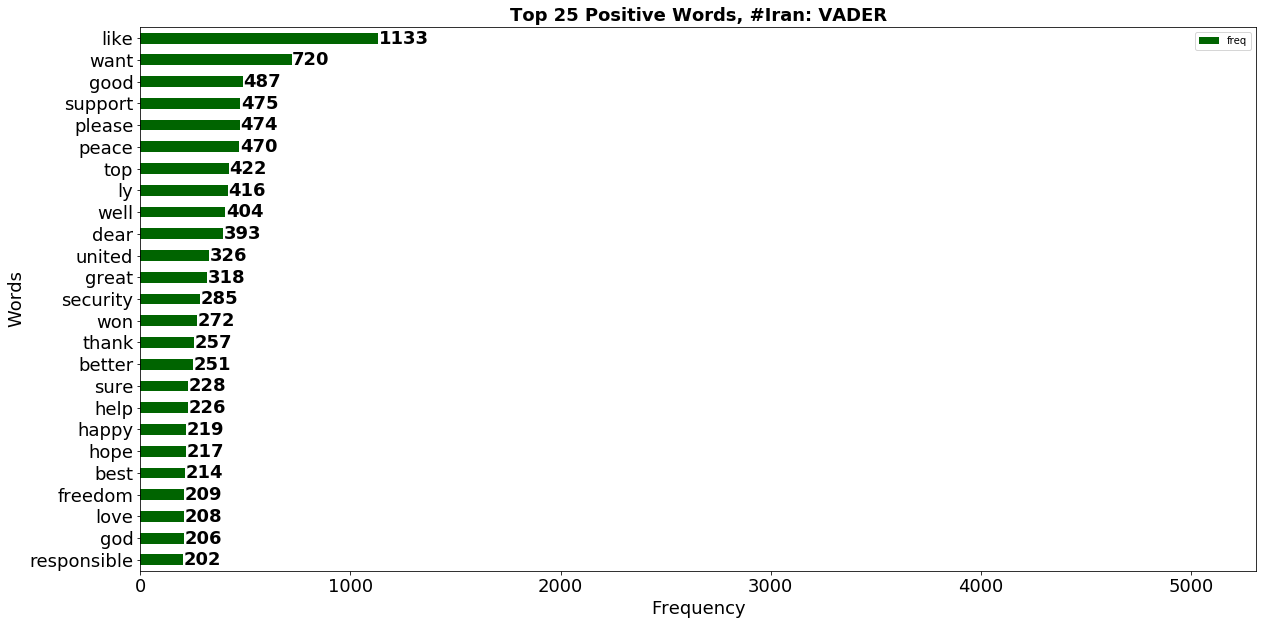

In [20]:
# Variables
posWordFile = "posWordsVader.svg"
posFmt = "svg"
posdpi = 600
posclr = ['darkgreen']
postitle = 'Top 25 Positive Words, #Iran: VADER'
pFigSz = (20,10)
pFntSz = 18

fig = posdf.plot(x= 'word',kind='barh', align='center', color = posclr, figsize = pFigSz, fontsize = pFntSz)
fig.set_ylabel('Words', fontsize = pFntSz)
fig.set_xlabel('Frequency', fontsize = pFntSz)
fig.set_title(postitle, fontweight='bold',fontsize = pFntSz)
fig.set_ylim(fig.get_ylim()[::-1])
fig.set_xlim(0,1500 + max(freqDF['freq']))

for i, v in enumerate(posdf['freq']):
    fig.text(v + 3, i + .25, str(v), color='black', fontweight='bold', fontsize = pFntSz )
    
plt.savefig(os.path.join(dataResults, posWordFile), format= posFmt, dpi=posdpi, bbox_inches='tight',)
plt.show()

###### Plot negative words

Here we plot the top negative words found in our dataset. The places where changes might need to be made are at the beginning of the cell under `# Variables`. First we name the output file and assign it to the variable `negWordFile`. Make sure to include the file type in the name ('.png', '.jpg', '.svg', et cetera) Then we choose the file format and assign it to the variable `negFmt`, making sure our format matches the file type in our file name. Now we decide on the resolution we want our output file to be and assign it to the variable `negdpi`.

Next we choose the color for the bars in our graph and assign it to the variable `negclr`.

Now, we choose the main title for out graph and assign it to the variable `negtitle`.

Then we choose the figure size. The first number is the width and the second is the height. We assign this to the variable `nFigSz`.

Lastly, we choose our font size and assign it to the variable `nFntSz`.

Most everything else in the code should not need to be changed.

Then plot the graph!

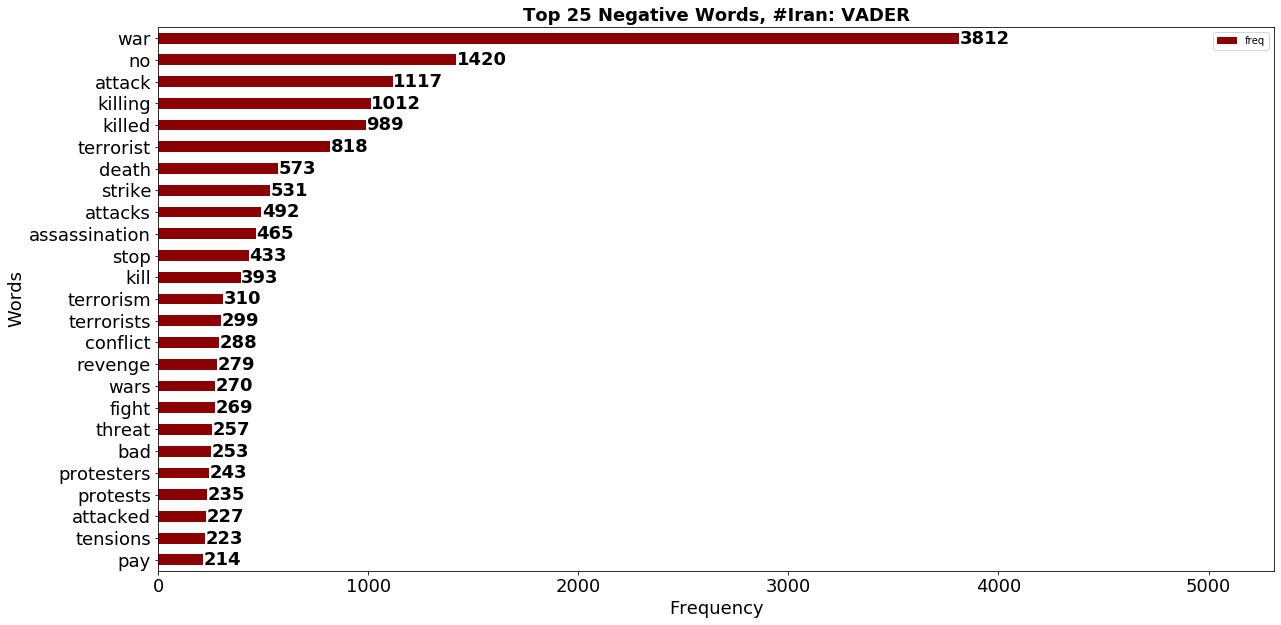

In [21]:
# Variables
negWordFile = "negWordsVader.svg"
negFmt = "svg"
negdpi = 600
negclr = ['darkred']
negtitle = 'Top 25 Negative Words, #Iran: VADER'
nFigSz = (20,10)
nFntSz = 18

# plot

fig = negdf.plot(x= 'word',kind='barh', align='center', color = negclr, figsize = nFigSz, fontsize = nFntSz)
fig.set_ylabel('Words', fontsize = nFntSz)
fig.set_xlabel('Frequency', fontsize = nFntSz)
fig.set_title(negtitle, fontweight = 'bold', fontsize = nFntSz)
fig.set_ylim(fig.get_ylim()[::-1])
fig.set_xlim(0,1500 + max(freqDF['freq']))

for i, v in enumerate(negdf['freq']):
    fig.text(v + 3, i + .25, str(v), color='black', fontweight='bold', fontsize = nFntSz)

    

plt.savefig(os.path.join(dataResults, negWordFile), format=negFmt, dpi=negdpi, bbox_inches='tight',)

plt.show()

## VOILA!!

This code was adapted from Stefan Sinclair's GitHub page called Art of Literary Text Analysis and can be found here: https://github.com/sgsinclair/alta/blob/e908bae2c224578485e10482e812924d7c6b7b05/ipynb/utilities/ComplexSentimentAnalysis.ipynb . Accessed 01/25/2019